In [42]:
import pyart
import numpy.ma as ma
import numpy as np
from scipy.stats import mstats
from statistics import mean
import warnings
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.geodesic as cargeo
from shapely.geometry import Polygon
import warnings
from cartopy.io.shapereader import Reader
import os
from cartopy.feature import ShapelyFeature
warnings.filterwarnings('ignore')

In [30]:
file_name="PHA210812102004(testcases).RAWKYLY"
radar = pyart.io.read_sigmet(file_name)
lat_0 = radar.latitude['data'][0]
lon_0 = radar.longitude['data'][0]
shape_grid = (7, 201,201)

In [31]:
class UF:
    def __init__(self,radar,shape_grid,lat_0, lon_0):
        self.radar = radar
        self.shape = shape_grid
        self.lat_0 = lat_0
        self.lon_0 = lon_0
    def noise_rejection(self):
        #reject noise radar
        range_bins=self.radar.range['data']
        ref_last_bins=self.radar.fields['reflectivity']['data'][:,-5:]
        Z_f=mstats.mode(ref_last_bins,axis=None)[0][0]
        Z_s=pyart.retrieve.compute_noisedBZ(1800, noisedBZ_val=Z_f, _range=range_bins, ref_dist=300., noise_field='noise_dbz')
        Z_splus4=Z_s['data']+4
        conditions_masked=ma.masked_less(self.radar.fields['reflectivity']['data'],Z_splus4)
        #mask Z<0
        self.radar.add_field_like('reflectivity', 'reflectivity_cor_noise',ma.masked_less_equal(conditions_masked,0.),replace_existing=True) 
        #self.radar.add_field_like('reflectivity', 'reflectivity_cor_noise',conditions_masked,replace_existing=True)
    def convert_grid(self):
        grid = pyart.map.grid_from_radars(
            self.radar,
            grid_shape=self.shape, #Number of points in the grid (z, y, x)
            grid_limits=((0, 9000), (-200000, 200000), (-200000, 200000)), # min-max tuong duong z,y,x
            grid_origin = (self.lat_0, self.lon_0),
            fields=['reflectivity_cor_noise'],
            roi_func='dist_beam',
            weighting_function='cressman')
        return grid
    def convert_lat_lon(self, grid):
        #conver distance to lat/lon
        for i in range(self.shape[1]):
            geog = pyart.core.cartesian_to_geographic_aeqd(grid.x["data"][i],grid.y["data"][i],self.lon_0, self.lat_0, R=6370997.0)
            grid.x["data"][i] = geog[0]
            grid.y["data"][i] = geog[1]
        return grid

In [32]:
UF_File = UF(radar, shape_grid, lat_0, lon_0)
ref_cor_noise=UF_File.noise_rejection()
grid = UF_File.convert_grid()
grid_lat_lon = UF_File.convert_lat_lon(grid)

In [33]:
lon=grid_lat_lon.x['data']
lat=grid_lat_lon.y['data']
lons,lats=np.meshgrid(lon,lat)
Zh=grid.fields['reflectivity_cor_noise']['data'][1,:,:]
Zh.mask=0

# Making YH95 Algorithm

In [34]:
YH95=np.zeros((shape_grid[1],shape_grid[2]))

In [35]:
#Step 1: Intensity
mask_st1=(Zh>=40)
YH95[mask_st1]=1

In [36]:
#Step 2: Peakeness
def MBG(xo,yo,n,r,Zh): #Mean Background Reflectivity
    y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
    mask = x*x + y*y <= r*r
    Zh_none_O=Zh[xo,yo]
    Zbg_ = np.ma.masked_array(Zh[mask], Zh[mask] ==Zh_none_O) # remove value cycle centers
    Zbg = np.ma.masked_array(Zbg_, Zbg_ == 0) # remove 0 values
    return Zbg
for xo in range (0,201,1):
    for yo in range (0,201,1):
        if YH95[xo,yo]==0:
            Zbg=MBG(xo,yo,201,5.5,Zh).mean()
            deltaZh=Zh[xo,yo]-Zbg
            if (Zbg < 43.43) and (deltaZh >= (10-Zbg**2/180)):
                YH95[xo,yo]=1
            elif Zbg>=43.43 and deltaZh>=0:
                YH95[xo,yo]=1

In [37]:
#Step3: Surrounding area
def MBG_mask_r(xo,yo,n,r): # mask array with r change
    y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
    mask = x*x + y*y <= r*r
    return mask
for xo in range (0,201,1):
    for yo in range (0,201,1):
        if YH95[xo,yo]==1:
            Zbg=MBG(xo,yo,201,5.5,Zh).mean()
            if Zbg < 25:
                r=0.5 #1km
            elif Zbg>=25 and Zbg <30:
                r=1   #2km
            elif Zbg>=30 and Zbg <35: 
                r=1.5 #3km
            elif Zbg>=35 and Zbg <40:
                r=2   #4km
            elif Zbg>=40:
                r=2.5 #5km
            mask_st2=MBG_mask_r(xo,yo,201,r=r)
            YH95[mask_st2]=2

In [38]:
#Step4: remaining ares as stratiform
for q in range (0,201,1):
    for l in range (0,201,1):
        if Zh[q,l]>0 and YH95[q,l] !=2:
            YH95[q,l]=1

In [39]:
#YH95=ma.masked_less_equal(YH95,0.)

# Plot map

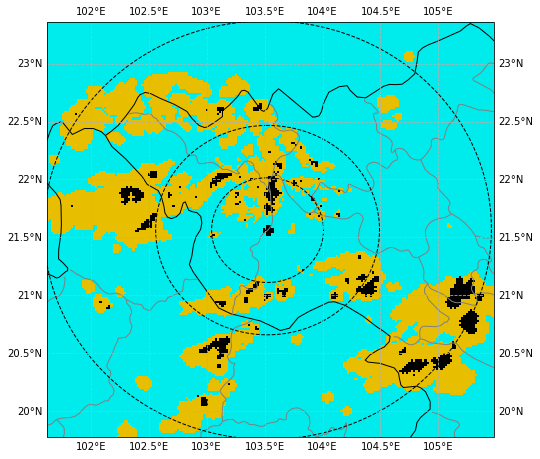

In [12]:
# Draw Range_Rings
circle_points_50km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=50000, n_samples=180, endpoint=False)
circle_points_100km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=100000, n_samples=180, endpoint=False)
circle_points_200km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=200000, n_samples=180, endpoint=False)
geom_50km=Polygon(circle_points_50km)
geom_100km=Polygon(circle_points_100km)
geom_200km=Polygon(circle_points_200km)
#plot map with datas
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.add_feature(cfeat.LAND)
ax.add_feature(cfeat.OCEAN.with_scale('10m'))
ax.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax.add_feature(state_provinces_lines,edgecolor='gray')
ax.gridlines(draw_labels=True,linestyle='--')
ax.set_extent((grid.x['data'][1],grid.x['data'][-1],grid.y['data'][1],grid.y['data'][-1]),crs=ccrs.PlateCarree())
ax.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax.pcolormesh(lons,lats,YH95,shading='flat',cmap=pyart.graph.cm.NWSRef)
ax.scatter(x=103.526,y=21.5632,transform=ccrs.PlateCarree(), color="black",s=100, alpha=1,marker='P');